# User agents family extraction by machine learning

## 1 Introduction

User agent string in HTTP header contains information about the browser and operation system[1]. However, as different browser sends user agent in different format, extracting information from user agent string is not easy.

Here's some sample user agent string:
* `Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1741.89 Safari/537.36`

* `Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 2.0.50727; .NET CLR 3.0.04506.30; .NET CLR 3.0.04506.648; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729`

* `Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0; KTXN B631976907A78190T950184P1) like Gecko`

The user agent family of the first one is `Chrome`, the second one belongs to `IE` family. The third one, however, looks very different from the second one, also belongs to `IE` family.

Detecting user agent family needs lots of prior knowledge about rules of different browsers. Moreover, knowing browsers and standards are not enough, there are plenty of edge cases needed to be considered. Although detecting user agent looks very easy, doing it well is very hard. Some APIs are provided to help people distinguish user agents family (such as [UseragentAPI](https://useragentapi.com/)).

In this tutorial, we are going to build a machine learning based model to extract user agent family **without** any prior knowledge about the browsers and rules.

## 2 Dataset

Dataset can be downloaded at [here](https://drive.google.com/open?id=1lsQrNN7O6HcXlG7wMPRIwC_6aJ5pdnXp).

The dataset contains three fields: 

`user agents`, `user agent family` and `user agent's major version`. 

These fields are separated by `\t`. The provided user agent family and user agent's major version can be considered as ground truth of the user agents. In this tutorial, we will only focus on detection of user agent family, so the third field can be ignored.

The categories of user family that the model should be able to identify:

`Chrome`,`Chrome Mobile`,`Chrome Mobile iOS`,
`Safari`, `Mobile Safari`,
`IE`, `IE Mobile`,
`Edge`,`Edge Mobile`,
`Firefox`, `Firefox Mobile`, `Firefox iOS`,
`Opera`, `Opera Mobile`, `Opera Mini`,
`UC Browser`, `Sogou Explorer`,
`QQ Browser`, `QQ Browser Mobile`,
`Maxthon`, `AOL`, `Facebook`,
`AppleMail`, `Puffin`, `Android`, `YandexSearch`, `BlackBerry WebKit`, `Amazon Silk`


The above are all the information given by the task. Details and statistics of dataset should be explored by ourselves.

## 3 Importing the libraries

In [1]:
import numpy as np
from operator import itemgetter
import re
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
import argparse
import pickle

## 4 Dataset analysis and preprocessing

### 4.1 Statistics

* Construct the dictionaty `uafamily_dict` (user agent family) where the key is family name and the value is the number of user agents belong to that family.


In [2]:
uafamily_dict = {'Chrome':0, 'Chrome Mobile':0, 'Chrome Mobile iOS':0, \
                 'Safari':0,'Mobile Safari':0, 'IE':0, 'IE Mobile':0, \
                 'Edge':0, 'Edge Mobile':0,'Firefox':0, 'Firefox Mobile':0, \
                 'Firefox iOS':0,'Opera':0, 'Opera Mobile':0,'Opera Mini':0, \
                 'UC Browser':0, 'Sogou Explorer':0,'QQ Browser':0,'QQ Browser Mobile':0,\
                 'Maxthon':0,'AOL':0,'Facebook':0,'AppleMail':0, 'Puffin':0, 'Android':0,\
                 'YandexSearch':0, 'BlackBerry WebKit':0, 'Amazon Silk':0}
# number of categories of user agent family
print("number of user agent families:")
print(len(uafamily_dict))
with open("datasets/data_user_agent.txt",'r') as f:
    for line in f:
        line = line.strip().split('\t')
        if line[1] in uafamily_dict:
            uafamily_dict[line[1]] += 1
        else:
            print(line) 
print()
print(uafamily_dict)
print()
print("The total number of data:")
print(sum(uafamily_dict.values()))

number of user agent families:
28

{'Chrome': 308656, 'Chrome Mobile': 50095, 'Chrome Mobile iOS': 911, 'Safari': 626, 'Mobile Safari': 2383, 'IE': 17426, 'IE Mobile': 305, 'Edge': 117, 'Edge Mobile': 116, 'Firefox': 1661, 'Firefox Mobile': 248, 'Firefox iOS': 73, 'Opera': 921, 'Opera Mobile': 1281, 'Opera Mini': 626, 'UC Browser': 5595, 'Sogou Explorer': 95, 'QQ Browser': 365, 'QQ Browser Mobile': 1745, 'Maxthon': 107, 'AOL': 100, 'Facebook': 18803, 'AppleMail': 120, 'Puffin': 75, 'Android': 8155, 'YandexSearch': 111, 'BlackBerry WebKit': 275, 'Amazon Silk': 224}

The total number of data:
421215


* Visualize the number of data for each user agent family

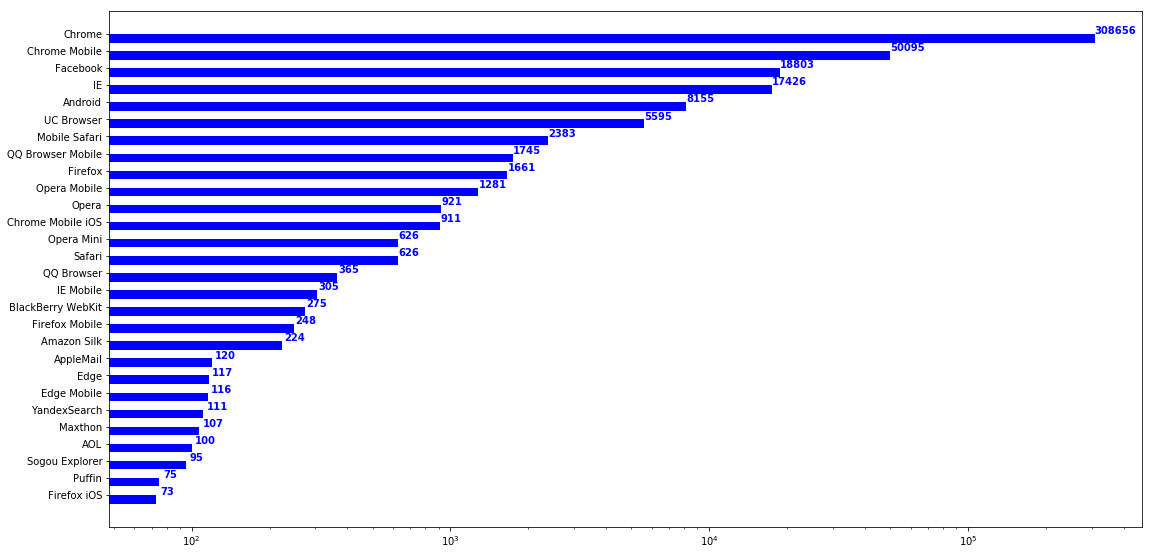

In [3]:
# Sorting at first
count_sorted = sorted(uafamily_dict.items(), key=itemgetter(1))
# Plot
x_axis = np.arange(len(uafamily_dict))
counts = [x[1] for x in count_sorted]
names = [x[0] for x in count_sorted]
width = 0.5
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 9.5)
ax.barh(x_axis, counts, width, color="blue")
ax.set_yticks(x_axis+width/2)
ax.set_yticklabels(names, minor=False)
ax.set_xscale("log", nonposx='clip')
for i, v in enumerate(counts):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

As the dataset is seriously unbalanced and long-tailed, log-scale is used for x-axis for better visualization.

### 4.2 Splitting Data
To verify the general performace of the model, and select best model/hyper-parameter, we should separate the dataset into two part: training data and validation data with ratio of 4: 1 for each category.

In [4]:
with open("datasets/myTrain.txt",'w') as f_train:
    with open("datasets/myVal.txt",'w') as f_val:
        with open("datasets/data_user_agent.txt",'r') as g:
            for line in g: 
                # 80% for myTrain
                lines = line.split('\t')
                if (random.randint(1, 10) > 2):
                    f_train.write(line)
                # 20% for myVal
                else:
                    f_val.write(line)

Now we have 337,057 data for training (stored in `datasets/myTrain.txt`) and 84,158 data for validation (stored in `datasets/myVal.txt`)

### 4.3 Prepocessing

Before feeding data into machine learning based model, we should prepare input and ground-truth labels.

#### 4.3.1 label preparation
User agents family extraction is a classification problem, and we would like to use Integers to represent different family name. For future convinent, we construct two dictionaries, `FAMILY_DICT` maps user agent family name to category number and `FAMILY_DICT2` maps category number to user agent family name.

In [5]:
# key - user agent family name, str; value - category number, int.
FAMILY_DICT = {'Chrome': 0, 'Chrome Mobile': 1, 'Chrome Mobile iOS': 2, 'Safari': 3,\
'Mobile Safari': 4, 'IE': 5, 'IE Mobile': 6, 'Edge': 7, 'Edge Mobile': 8, 'Firefox': 9, \
'Firefox Mobile': 10, 'Firefox iOS': 11,'Opera': 12, 'Opera Mobile': 13, 'Opera Mini': 14,\
'UC Browser': 15, 'Sogou Explorer': 16, 'QQ Browser': 17, 'QQ Browser Mobile': 18, \
'Maxthon': 19, 'AOL': 20, 'Facebook': 21, 'AppleMail': 22, 'Puffin': 23, 'Android': 24, \
'YandexSearch': 25, 'BlackBerry WebKit': 26, 'Amazon Silk': 27}

# key - category number, str; value - user agent family name, int.
FAMILY_DICT2 = {0:'Chrome', 1:'Chrome Mobile', 2:'Chrome Mobile iOS', 3:'Safari',\
4:'Mobile Safari', 5:'IE', 6:'IE Mobile', 7:'Edge', 8:'Edge Mobile', 9:'Firefox', \
10:'Firefox Mobile', 11:'Firefox iOS', 12:'Opera', 13:'Opera Mobile', 14:'Opera Mini', \
15:'UC Browser', 16:'Sogou Explorer', 17:'QQ Browser', 18:'QQ Browser Mobile',\
19:'Maxthon', 20:'AOL', 21:'Facebook', 22:'AppleMail', 23:'Puffin', 24:'Android', \
25:'YandexSearch', 26:'BlackBerry WebKit', 27:'Amazon Silk'}


#### 4.3.2 input preparation
For each user agent string, we want to extract features to feed into the classification model. As we do NOT have any prior knowledge about the rules, we just simply do some string parsing and convert user agent into bag of words. And then use TF-IDF features as input to train the model.

We should notice that number of TF-IDF features to use is a hyperparameter. We will try different value of number of features and select the best one based on performance on validation data.

Following codes are implementation for label preparation and input preparation.

In [6]:
def parseString(string):
    """
    Helper function to parse user agent string into list of strings 
    Inputs:
    - string: user agent string to be parsed
    Returns:
    - content_list_i: list of parsed strings for the input user agent string
    
    """
    ## ith content_list
    content_list_i = []
    lst = re.findall('\[[^\]]*\]|\([^\)]*\)|\S+',string)
    # special processing for the first element
    content_list_i.append(lst[0].strip())
    # special processing for the second element
    ele2 = lst[1][1:-2]
    lst2 = re.findall('\;|\S+', ele2)
    for item in lst2:
        # remove part has no a-zA-Z
        if re.sub("[^a-zA-Z]", "", item) != "":
            content_list_i.append((item.strip(";")).strip())
    # other part
    if len(lst) > 2:
        for item in lst[2:]:
            item = (item.strip("[")).strip("]")
            # remove part has no a-zA-Z
            if re.sub("[^a-zA-Z]", "", item) != "":
                content_list_i.append(item.strip())
    return content_list_i

def processFiles(filename):
    """
    Read file, extract meaningful words in user agent and get the groundtruth of browser family.
    Inputs:
    - x: path of data file
    Returns:
    - content_list: list of meaningful words for N user agents
    - y: list of browser family index for N user agents
    """
    i = 0
    content_list = [] 
    y = []
    with open(filename,'r') as f:
        for line in f:
            line = line.strip().split('\t')
            ## ith category number
            y_i = FAMILY_DICT[line[1]]
            y.append(y_i)
            content_list_i = parseString(line[0])          
            content_list.append("/".join(content_list_i))
            i += 1
    return content_list, y
def tokenize(text):
    """
    Helper function for tfidfVectorizer.
    """
    return text.split('/')

def tfidfVectorizer(content_list, max_feature):
    """
    Convert content_list to TF-IDF features. 
    Inputs:
    - content_list: list of meaningful words for N user agents
    Returns:
    - X: a numpy array for user agents features, of shape (N, MAX_FEATURES)
    - vectorizer: model for tfidfVectorizer, for further use of test data conversion
    - vocab: list of selected features
    """
    vectorizer = TfidfVectorizer(analyzer = "word",  \
                                tokenizer = tokenize,   \
                                preprocessor = None, \
                                stop_words = None,   \
                                lowercase = False,\
                                max_features = max_feature)
    X = vectorizer.fit_transform(content_list)
    X = X.toarray()
    vocab = vectorizer.get_feature_names()
    return X, vectorizer, vocab

processing the training files and validation files:

In [7]:
train_file = "datasets/myTrain.txt"
val_file = "datasets/myVal.txt"
# process files 1
content_list_train, y_train = processFiles(train_file)
content_list_val, y_val = processFiles(val_file)

## 5 Approach and Experiment

### 5.1 Approach
As mentions before, predicting user agent family is a classification problem. Which model should be used? 

Recent success of neural networks shows that they perform well in classification problem. However, large amount of balanced data are needed to train a good neural network. Considering unbalanced data is not suitable for neural networks, we should either resample the data or use other models.

Another choice is decision tree, as decision tree is a classification model and often achieves good result on imbalanced dataset in practice. [[2]](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) Hence, in this tutorial, we select `decision tree` to build our classification model. (To learn more details/theory about Decision Tree, you can refer to Lecture Notes or [this tutorial](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/) )

For implementation, we can use `tree` package in `sklearn`, which is simple and easy to use. Here is sample code:
```
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
# predict 
clf = clf.fit(X_test, y_test)
y_predict = clf.predict(X_test)
```
You can explore more usage of `DecisionTreeClassifier` in its [doc](http://scikit-learn.org/stable/modules/tree.html). 
### 5.2 Training

Remember that the main hyperparameter we need to select in the number of input features. Given the number of feature, we should train the tree on training data, and calculate the accuracy in validation data. Then select the one achieve highest validation accuracy.

In [11]:
def train_and_select(max_feature):
    global content_list_train, y_train, content_list_val, y_val
    # print("########## Train with {} features ##########".format(max_feature))
    # convert to tf-idf features
    X_train, vectorizer, vocab = tfidfVectorizer(content_list_train, max_feature)
    # print("X_train shape {}, y_train len {}".format(X_train.shape, len(y_train)))
    # shuffle training data
    new_order = np.arange(X_train.shape[0])
    np.random.shuffle(new_order)
    X_train_shuffle = X_train[new_order]
    # array to np
    y_train = np.array(y_train)
    y_train_shuffle = y_train[new_order]
    # np to array
    y_train_shuffle = [int(x) for x in y_train_shuffle.tolist()]
    # decision tree
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    train_score = clf.score(X_train_shuffle, y_train_shuffle)
    # for prediction
    # process files
    X_val = vectorizer.fit_transform(content_list_val)
    X_val = X_val.toarray()
    # print("X_val shape {}, y_val len {}".format(X_val.shape, len(y_val)))
    # predict 
    y_predict = clf.predict(X_val)
    val_score = clf.score(X_val, y_val)
    #print("val score: {}".format(clf.score(X_val, y_val)))
    return train_score, val_score, vectorizer, clf

Training and Visualization for selecting number of features:

/Users/haoying/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


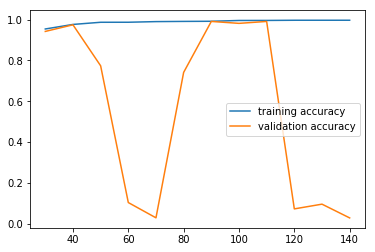

In [12]:
score_train = []
score_val = []
for num_feature in range(30, 150, 10):
    train_score, val_score, _, _ = train_and_select(num_feature)
    score_train.append(train_score)
    score_val.append(val_score)

# plot
x = np.arange(30, 150, 10)
plt.plot(x, score_train)
plt.plot(x, score_val)
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

From the Figure above, when 90 features ares used, the validation accuracy becomes the highest. Although using more features can achieve the same validation accuracy, to avoid overfitting and keep the model as simple as possible, 90 is selected as the number of features.

## 6 Save model for future prediction

### 6.1 save model

From part 5, we selected our hyper-parameter: 90 for number of features. Now, we can save the necessary models for future prediction.

In particular, we should save `vectorizer` to extract TF-IDF features and `clf` for prediction. We can use `pickle` to save these two objects.

In [13]:
train_score, val_score, vectorizer, clf = train_and_select(90)
print("train score: {}".format(train_score))
print("val score: {}".format(val_score))
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('decision_tree.pkl', 'wb') as f:
    pickle.dump(clf, f)

/Users/haoying/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


train score: 0.9914868489768789
val score: 0.9905114776681273


### 6.2 load model for prediction
now we can load trained models to predict any user agent string

In [14]:
def predict(string):
    # load models
    with open('decision_tree.pkl', 'rb') as f:
        clf = pickle.load(f)
    with open('vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    # parse the string
    global content_list_val
    content = parseString(string)         
    content_list_val.append("/".join(content))
    # convert to tf-idf feature
    X_test = vectorizer.fit_transform(content_list_val)
    X_test = X_test.toarray()
    del content_list_val[-1]
    # predict
    y_predict = clf.predict(X_test[-1])
    return FAMILY_DICT2[y_predict[0]]

Now we can use our model to predict the family of sample user agent string showed in `Introduction` part

In [15]:
user_agent = "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1741.89 Safari/537.36"
pred_family = predict(user_agent)
print("the predicted family is {} [ground truth: Chrome]".format(pred_family))

user_agent = "Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 2.0.50727; .NET CLR 3.0.04506.30; .NET CLR 3.0.04506.648; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729"
pred_family = predict(user_agent)
print("the predicted family is {} [ground truth: IE]".format(pred_family))

user_agent = "Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0; KTXN B631976907A78190T950184P1) like Gecko"
pred_family = predict(user_agent)
print("the predicted family is {} [ground truth: IE]".format(pred_family))


/Users/haoying/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/Users/haoying/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


the predicted family is Chrome [ground truth: Chrome]


/Users/haoying/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


the predicted family is IE [ground truth: IE]
the predicted family is IE [ground truth: IE]


/Users/haoying/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


## 7 Discussion

In this tutorial, we have discussed how to use data science and machine learning techniques to find out user agent family from any user agent string, even though we do not know any rules about user agent generation!!

We start from analyzing the training dataset, and find out the dataset is unbalanced. So we select `Decision Tree` as it often achieves good result even on unbalanced dataset. Before training, we preprocess and vectorize the user agent strings. On the validation dataset, we can achieve 99.05% accuracy by selecting the best hyperparameter. And our model works well on classification of sample user agent strings.

There is still room to improve the model accuracy. To solve imbalanced data problem, some techniques such as resampling and bagging could be adopted. After balancing the data, more classification models such as neural networks could be used to solve this problem.


### References

[1] https://en.wikipedia.org/wiki/User_agent

[2] https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
